<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Learning" data-toc-modified-id="Deep-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Learning</a></span><ul class="toc-item"><li><span><a href="#Tensorflow/Keras" data-toc-modified-id="Tensorflow/Keras-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tensorflow/Keras</a></span></li><li><span><a href="#Training-Dataset" data-toc-modified-id="Training-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training Dataset</a></span></li><li><span><a href="#Single-Layer-Neural-Network" data-toc-modified-id="Single-Layer-Neural-Network-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Single Layer Neural Network</a></span></li><li><span><a href="#Multilayer-Perceptron-Model" data-toc-modified-id="Multilayer-Perceptron-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Multilayer Perceptron Model</a></span></li><li><span><a href="#Model-vs-Sequential-Classes" data-toc-modified-id="Model-vs-Sequential-Classes-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model vs Sequential Classes</a></span></li><li><span><a href="#Changing-Activation-Functions-and-Depths" data-toc-modified-id="Changing-Activation-Functions-and-Depths-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Changing Activation Functions and Depths</a></span></li><li><span><a href="#Deep-Example" data-toc-modified-id="Deep-Example-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Deep Example</a></span></li></ul></li></ul></div>

In [1]:
# Preliminary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # Note: if you are using anaconda, you may need to conda install tensorflow and some of its dependencies

## Deep Learning ##
### Tensorflow/Keras ###
Tensorflow is the open-source library developed by google for creating and training neural networks. In its native form, tensorflow is challenging to use and so shortly after it was released a python library called keras was developed to provide high-level access/API to tensorflow functionality. Keras was originally independent of tensorflow, and only used it as one of several "backends" that actually did the heavy lifting. However, Keras gained so much popularity that it was eventually incorporated into tensorflow as a library. 

I'm giving you this history lesson, because it can be confusing to navigate some of the online docs regarding keras because depending on the date of the doc you are consulting, it may be referring to the stand-alone Keras library, which is no longer being updated but still exists, or the Tensorflow.keras library which is what you should be using. 

In this notebook, I'll illustrate basic model construction and training using the relevant `tensorflow.keras` classes. Even using keras, complex architectures can be formidable to implement and I can't comprehensively cover everything in this notebook. You can consider this an entry point to understand the logic of the package and entry point for further study in your research projects. 

### Training Dataset ###
We'll use the pump dataset as our modeling target for our illustrations. In the cell below, let's load the data and define a plotting function to simplify our later cells:


       Inlet_Diameter_(cm)  Maximum_Capacity_(GPM)  Max_Head_(ft)  \
count           150.000000              150.000000     150.000000   
mean             15.135587            14700.096623     542.923830   
std               0.481500              189.738274       1.516724   
min              14.102436            14258.800630     539.369207   
25%              14.862139            14611.595240     541.828181   
50%              15.097686            14683.594165     542.949154   
75%              15.470908            14798.056495     544.047032   
max              16.100000            15162.585260     546.154856   

       Minimum_Thickness_(mm)  
count              150.000000  
mean                10.342815  
std                  0.472594  
min                  9.273588  
25%                 10.060062  
50%                 10.343106  
75%                 10.692270  
max                 11.427964  


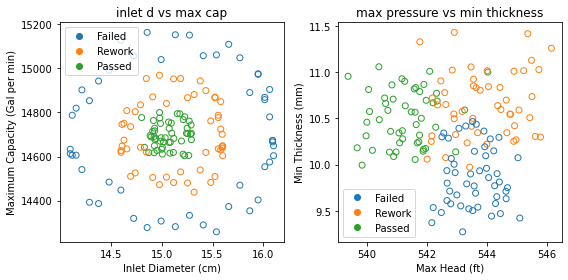

In [2]:
import matplotlib.cm as cm
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split

features = pd.read_csv('features.txt', delimiter=r"\s+")
labels = pd.read_csv('labels.txt',header=None)

# print out summary statistics for each feature
print(features.describe())

# Make the data arrays
X = features.to_numpy()
label_dict = { i:count_i for count_i,i in enumerate(set(labels[0])) }
Y = np.array([ label_dict[_] for _ in labels[0] ])

# Generate the training/testing split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=135323)

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make plots
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()


### Single Layer Neural Network

We'll start by training a single layer fully connected network. This is essentially just a cluster of logistic functions that directly map inputs and outputs. These types of networks are similar to other types of machine learning methods, such as support vector machines and logistic regression. We will construct such a model using the Keras high level API.

For this model, we will utilize a single, fully connected layer of 3 units. That is, each input parameter (4 in the pump example) is fed to each of the 3 units. The units do no commnicate with each other. Each will use some linear combination of the inputs multiplied by a weighting factor, and will mediate their output through a nonlinear activation function. Here, because we are considering a classification task, we utilize the 'softmax' activation function. This will output a set of normalized probability values ( i.e. 0.3,0.5,0.2 ) corresponding to the probability that a given class has been observed. In such a model, the predicted label would correspond to whichever index has the largest probability. 

Because we are dealing with a classification task with three possible outputs (Pass,Rework,Fail) we utilize the categorical crossentropy loss function, which penalizes output distributions that diverge from the input distribution.

$$ CE = -\sum_{i}^{N}\sum_{c}^{N_\mathrm{C}}t_c \mathrm{log}\left(p_{c}\right) $$

where the first summation is over all of the training samples and the second summation runs over the class labels (e.g., $N_\mathrm{C} = 3$ in the current example). In the model configuration, a prediction will occur along the lines of [0.1,0.8,0.1] where the probability of each class is predicted for every instance. The summation in the equation thus runs over these elements, where $t_i$ is the value in training label (i.e., either 1 or 0) and $p_i$ is the prediction from the model (i.e., a number between 0 and 1). Note that in the event of a perfect prediction this loss goes to zero. When the problem has multiple concurrent labels (e.g., [1,1,0]) the cross-entropy is similar to the gini impurity in that it tends to penalize multiple equally erroneous labels in favor of a mix of correct and incorrect labels. The stochastic gradient descent (SGD) optimizer is used to handle backpropagation.

That's a lot to take in, but we'll break the model construction and training into smaller pieces. First let's do some preliminary imports from Keras with some descriptive comments: 


In [3]:
# We still need to standardize the input data to effectively train the model. We will use the sklearn scaler to do this
from sklearn.preprocessing import StandardScaler

# After getting the predictions we can use our favorite sklearn metrics to assess the results
from sklearn.metrics import classification_report

# Import relevant tf.keras classes
# First, these are the two layer classes that we need (i.e., an input layer and a fully connected layer)
from tensorflow.keras.layers import Input,Dense

# We need the model class, which is the thing that collects the layer instances into a single object
from tensorflow.keras.models import Model

# We can use some helper functions. to_categorical will go to the one-hot class and plot_model will make a nice model diagram
from tensorflow.keras.utils import to_categorical, plot_model

# During training we want to calculate some statistics for how it is going. The built-in error metrics live inside the tf.keras.metrics module
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


I have annotated each of the imports in the cell above and you will get to see them in action in a moment. Here I will just note that sklearn and tf can work together, since numpy arrays are supplied at training and return by our NN as predictions. Thus, on the front-end we can use sklearn to help with standardizing our training data, and on the back-end we can analyze our results with sklearn error functions that aren't natively available in tf.keras. 

Next, let's build the model:

In [40]:
# Avoids making duplicate models if you rerun these cells
tf.keras.backend.clear_session()
tf.random.set_seed(54238789) # for reproducibility

# Initialize input layer (Note the shape, we have four input features)
input_layer = Input(shape=(4,))

# Connect output layer to input layer (Note the shape, we have three classes in our y)
output_layer = Dense(3,activation = 'softmax')(input_layer)

# Create the model
model = Model(inputs=input_layer,outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=[Precision(), Recall(), CategoricalAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


Keras provides a few ways to build models. Here we are illustrating the layer-by-layer approach, where we initialize layer instances corresponding to each layer in our model, then we combine them in a `Model` class. Once the model class is initialized, it has a method called `Model.compile()` that let's us declare the optimizer, loss function, and metrics that we want to calculate during the training. The `Model` class also has a nice `Model.summary()` method that gives us an overview of the layers and number of parameters. In this case we have 4 inputs, fully connected to 3 output nodes. That is 4x3 weights, plus 3 biases on the output nodes, yielding 15 total trainable parameters. 

Keras also provides a helper function called `tf.keras.utils.plot_model()` that makes a diagram of our model:

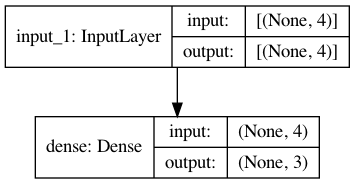

In [41]:
# Plot the model diagram
tf.keras.utils.plot_model(model, show_shapes=True)

For the current example, `plot_model()` is probably overkill, but for more complex networks it is useful to see the model diagrammed out in this way, with the various input and output dimensions of each layer reported. 

<b>Note:</b> the plot_model() function has a dependence on `graphviz` and `pydot` that may not automatically come with your anaconda distribution. You will need to install these using conda or pip if you want to generate these diagrams. If you don't want to do this, you should be able to run the rest of the cells without them. 

Finally, we are ready to train our model. Similar to scikit learn, this happens through the `Model.fit()` method after we have compiled our model and declared the various attributes of the training. Some other hyperparameters (e.g., `batch`) are also supplied to the `fit()` method. 

In [42]:
# Initialize scalar object for features
scaler = StandardScaler().fit(x_train)

# Train the model using sgd and 100 epochs
history=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=100,verbose=1,batch_size=10,\
                    validation_data=(scaler.transform(x_test), to_categorical(y_test)))

Epoch 1/100
12/12 [==============================] - 1s 25ms/step - loss: 1.2066 - precision: 0.5097 - recall: 0.3714 - categorical_accuracy: 0.5425 - val_loss: 0.8815 - val_precision: 0.7619 - val_recall: 0.5333 - val_categorical_accuracy: 0.6667
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 1.0914 - precision: 0.6125 - recall: 0.4576 - categorical_accuracy: 0.5896 - val_loss: 0.8512 - val_precision: 0.8095 - val_recall: 0.5667 - val_categorical_accuracy: 0.7000
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0224 - precision: 0.6289 - recall: 0.4378 - categorical_accuracy: 0.5587 - val_loss: 0.8226 - val_precision: 0.8095 - val_recall: 0.5667 - val_categorical_accuracy: 0.7000
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.9993 - precision: 0.5968 - recall: 0.4529 - categorical_accuracy: 0.5756 - val_loss: 0.7959 - val_precision: 0.8095 - val_recall: 0.5667 - val_categorical_accuracy: 0.7333
Epoch 5/100

12/12 [==============================] - 0s 4ms/step - loss: 0.5751 - precision: 0.8968 - recall: 0.7039 - categorical_accuracy: 0.7796 - val_loss: 0.4813 - val_precision: 1.0000 - val_recall: 0.8000 - val_categorical_accuracy: 0.9000
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5001 - precision: 0.9216 - recall: 0.7403 - categorical_accuracy: 0.8145 - val_loss: 0.4779 - val_precision: 1.0000 - val_recall: 0.8000 - val_categorical_accuracy: 0.9333
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5791 - precision: 0.8827 - recall: 0.6697 - categorical_accuracy: 0.7633 - val_loss: 0.4747 - val_precision: 1.0000 - val_recall: 0.8000 - val_categorical_accuracy: 0.9333
Epoch 37/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5011 - precision: 0.9454 - recall: 0.7268 - categorical_accuracy: 0.8301 - val_loss: 0.4716 - val_precision: 1.0000 - val_recall: 0.8000 - val_categorical_accuracy: 0.9333
Epoch 38/100
12/12 [=

12/12 [==============================] - 0s 4ms/step - loss: 0.4344 - precision: 0.8883 - recall: 0.7746 - categorical_accuracy: 0.8124 - val_loss: 0.4148 - val_precision: 1.0000 - val_recall: 0.8333 - val_categorical_accuracy: 0.9000
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4449 - precision: 0.9111 - recall: 0.8049 - categorical_accuracy: 0.8356 - val_loss: 0.4136 - val_precision: 1.0000 - val_recall: 0.8333 - val_categorical_accuracy: 0.9000
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.4813 - precision: 0.8950 - recall: 0.7824 - categorical_accuracy: 0.8137 - val_loss: 0.4124 - val_precision: 1.0000 - val_recall: 0.8333 - val_categorical_accuracy: 0.9000
Epoch 70/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5320 - precision: 0.8781 - recall: 0.7344 - categorical_accuracy: 0.7803 - val_loss: 0.4112 - val_precision: 1.0000 - val_recall: 0.8333 - val_categorical_accuracy: 0.9000
Epoch 71/100
12/12 [=

12/12 [==============================] - 0s 3ms/step - loss: 0.4150 - precision: 0.8527 - recall: 0.7922 - categorical_accuracy: 0.8118 - val_loss: 0.3832 - val_precision: 1.0000 - val_recall: 0.8667 - val_categorical_accuracy: 0.9000


A few important things have occured in this cell. First, we are using the `StandardScalar()` class to standardize our x-features before training. This is the same thing that we have done before, but we are illustrating that you can use sklearn as part of your pre-processing workflow. Second, we are using the `to_categorical()` function to convert our y values to the correct form. Recall, our y values are just a label, whereas our model needs a 1x3 vector of ones and zeros for each sample. Let's take a close look at what this is doing:

In [43]:
# Illustrate what to_categorically() is doing.
converted = to_categorical(y_train)
for count_i,i in enumerate(y_train):
    print("{} -> {}".format(i,converted[count_i,:]))

2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
1 -> [0. 1. 0.]
1 -> [0. 1. 0.]
2 -> [0. 0. 1.]
2 -> [0. 0. 1.]
1 -> [0. 1. 0.]
0 -> [1. 0. 0.]
2 -> [0. 0. 1.]
1 -> [0.

Finally, we have trained our model and supplied it with some validation data that we want it to calculate error metrics on as it trains (i.e., the `validation_data` argument). You can see the training progress printed off at each epoch, because we used the `verbose=1` option, otherwise nothing would have been printed to standard out. We don't really need the `verbose=1` option, because the `Model.fit()` method returns the training details which we capture using the `history` pointer which is essentially a dictionary with the various statistics at each epoch:

history keys: dict_keys(['loss', 'precision', 'recall', 'categorical_accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_categorical_accuracy'])


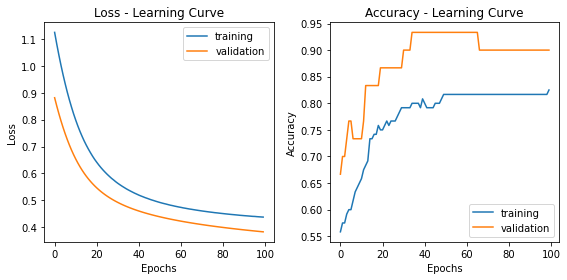

In [44]:
print("history keys: {}".format(history.history.keys()))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(np.arange(len(history.history["loss"])),history.history["loss"],label="training")
plt.plot(np.arange(len(history.history["loss"])),history.history["val_loss"],label="validation")
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
plt.plot(np.arange(len(history.history["categorical_accuracy"])),history.history["categorical_accuracy"],label="training")
plt.plot(np.arange(len(history.history["val_categorical_accuracy"])),history.history["val_categorical_accuracy"],label="validation")
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

We have generated our learning curves using the `history.history` dictionary. Note that the model is still saved in memory at this point. So if you look at the curves and wonder if you should have trained a little longer, you can:

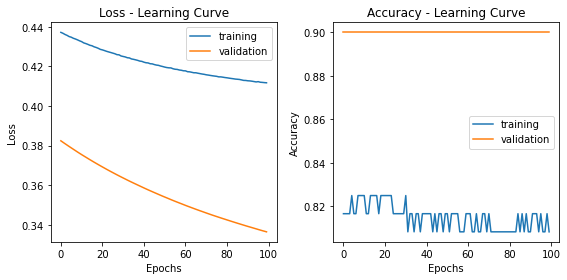

In [45]:
# Train the model using sgd and 100 epochs
history=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=100,verbose=0,batch_size=10,\
                    validation_data=(scaler.transform(x_test), to_categorical(y_test)))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(np.arange(len(history.history["loss"])),history.history["loss"],label="training")
plt.plot(np.arange(len(history.history["loss"])),history.history["val_loss"],label="validation")
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
plt.plot(np.arange(len(history.history["categorical_accuracy"])),history.history["categorical_accuracy"],label="training")
plt.plot(np.arange(len(history.history["val_categorical_accuracy"])),history.history["val_categorical_accuracy"],label="validation")
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Note that the model has picked up where it left off. The loss continues to call, but the model accuracy has plateaued.

The last thing to do is generate the actual predicted labels with our model using the `Model.predict()` method: 

In [46]:
predictions = model.predict(scaler.transform(x_test))
for count_i,i in enumerate(y_test):
    print("{} : {}".format(i,predictions[count_i]))

0 : [0.6177614  0.34464324 0.03759535]
1 : [0.07616617 0.90408427 0.01974963]
0 : [0.8805375  0.0551772  0.06428528]
1 : [0.16098681 0.48489758 0.35411566]
2 : [0.03220062 0.4577406  0.5100588 ]
0 : [0.68620193 0.19326305 0.12053499]
1 : [0.01861818 0.47442153 0.5069603 ]
1 : [0.4630421 0.4231049 0.113853 ]
2 : [1.5689321e-04 3.7990578e-03 9.9604404e-01]
2 : [0.14003883 0.08734636 0.7726148 ]
0 : [0.9262813  0.07052482 0.00319391]
0 : [0.9700963  0.02556803 0.00433567]
0 : [0.6231433  0.31005335 0.0668033 ]
0 : [0.7567913  0.09719481 0.14601386]
1 : [0.03160252 0.9519108  0.01648668]
2 : [0.0302272  0.26904324 0.7007295 ]
0 : [0.9810097  0.01696536 0.00202496]
2 : [0.07532603 0.01978482 0.9048891 ]
2 : [0.00376027 0.1017023  0.89453745]
1 : [0.00964032 0.9889948  0.00136492]
2 : [0.11985157 0.13446815 0.7456803 ]
2 : [0.04596548 0.35354942 0.6004851 ]
0 : [0.9224032  0.03273002 0.04486684]
0 : [0.8253453  0.04642987 0.12822483]
1 : [0.28720868 0.54888415 0.16390717]
0 : [0.8668877  0.0

Here I am printing out the testing data labels and the predctions to remind you of their distinct formats. Specifically, the labels are just integers corresponding to the class, whereas the predictions are in the form of one-hots (i.e., vectors or matrices where each column corresponds to a class). To make a direct comparison with the testing labels, we need to grab the index of the maximum probability element. `np.argmax()` makes this easy:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.86      0.75      0.80         8
           2       0.90      1.00      0.95         9

    accuracy                           0.90        30
   macro avg       0.89      0.89      0.89        30
weighted avg       0.90      0.90      0.90        30



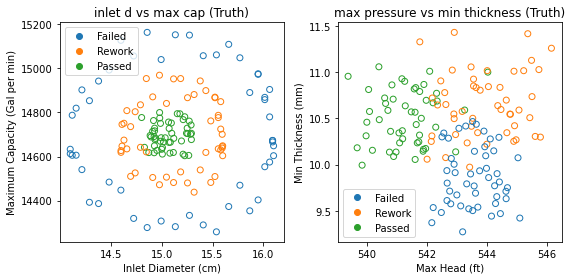

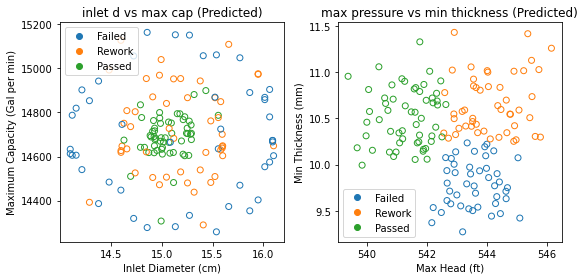

In [47]:
predictions = model.predict(scaler.transform(x_test))
predictions = np.argmax(predictions, axis=1)

# Print performance summary using sklearn classification_report() function
print(classification_report(y_test,predictions))

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make reference plots
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap (Truth)')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness (Truth)')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()

# Make prediction plots
YP = model.predict(scaler.transform(X)) # Predictions on training + testing
YP = np.argmax(YP, axis=1)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(YP))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap (Predicted)')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(YP))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness (Predicted)')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()

### Multilayer Perceptron Model ###
The logical way that tf.keras builds models makes it quite easy to add nodes or layers with just a line or two of extra code. Let's add a layer to our model with 20 nodes and test it out. We'll consolidate the work flow into a single cell now that we have demonstrated the individual elements in the last section: 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


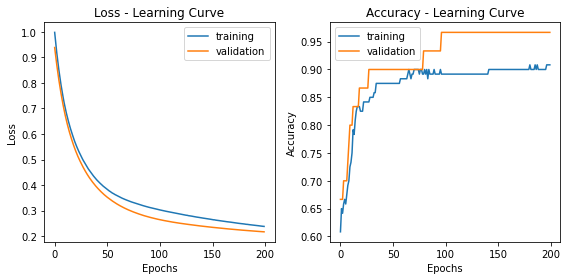

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         9

    accuracy                           0.97        30
   macro avg       0.98      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



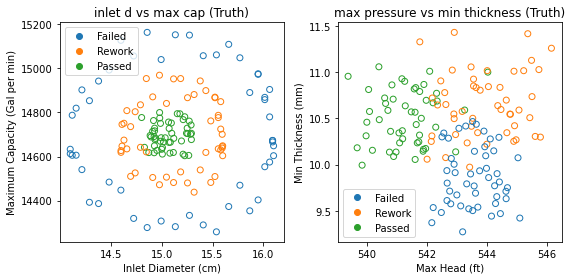

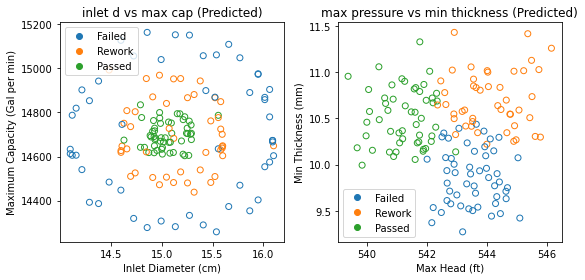

In [48]:
# Avoids making duplicate models if you rerun these cells
tf.keras.backend.clear_session()
tf.random.set_seed(54238789) # for reproducibility

# Initialize input layer (Note the shape, we have four input features)
input_layer = Input(shape=(4,))

# Initialize a dense hidden layer (Note the distinct activation function)
hidden_layer = Dense(20,activation = 'relu')(input_layer)

# Connect output layer to input layer (Note the shape, we have three classes in our y)
output_layer = Dense(3,activation = 'softmax')(hidden_layer)

# Create the model
model = Model(inputs=input_layer,outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=[Precision(), Recall(), CategoricalAccuracy()])
model.summary()

# Train the model
history=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=200,verbose=0,batch_size=10,\
                    validation_data=(scaler.transform(x_test), to_categorical(y_test)))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(np.arange(len(history.history["loss"])),history.history["loss"],label="training")
plt.plot(np.arange(len(history.history["loss"])),history.history["val_loss"],label="validation")
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
plt.plot(np.arange(len(history.history["categorical_accuracy"])),history.history["categorical_accuracy"],label="training")
plt.plot(np.arange(len(history.history["val_categorical_accuracy"])),history.history["val_categorical_accuracy"],label="validation")
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

predictions = model.predict(scaler.transform(x_test))
predictions = np.argmax(predictions, axis=1)

# Print performance summary using sklearn classification_report() function
print(classification_report(y_test,predictions))

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make reference plots
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap (Truth)')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(Y))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness (Truth)')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()

# Make prediction plots
YP = model.predict(scaler.transform(X)) # Predictions on training + testing
YP = np.argmax(YP, axis=1)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features["Inlet_Diameter_(cm)"],features["Maximum_Capacity_(GPM)"],facecolor='None',marker='o',edgecolors=cm.tab10(YP))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('inlet d vs max cap (Predicted)')
plt.legend(handles=[fail,rework,passed])

plt.subplot(122)
plt.scatter(features["Max_Head_(ft)"],features["Minimum_Thickness_(mm)"],facecolor='None',marker='o',edgecolors=cm.tab10(YP))
plt.xlabel("Max Head (ft)")
plt.ylabel('Min Thickness (mm)')
plt.title('max pressure vs min thickness (Predicted)')
plt.legend(handles=[fail,rework,passed])
plt.tight_layout()
plt.show()

### Model vs Sequential Classes ###
If you are just making neural networks without branches (i.e., just stacked layers) an alternative to the `Model` class is the `Sequential` class. When using `Sequential` you use the `add()` method of the class to add each layer to the stack rather than specify the connections directly using the `Layer()(where)` type calls when compiling using the `Model` class.

Let's illustrate making a regression model with one predictor variable using these two approaches. 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


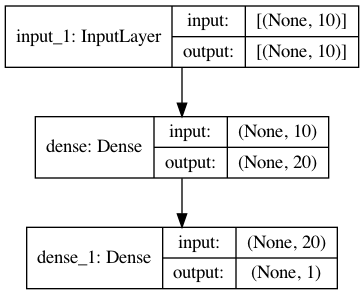

In [19]:
# Model approach
tf.keras.backend.clear_session() # resets model
input_layer = Input(shape=(10,))
hidden_layer = Dense(20,activation = 'relu')(input_layer)
output_layer = Dense(1)(hidden_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])
model.summary()

# Plot the model diagram
tf.keras.utils.plot_model(model, show_shapes=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


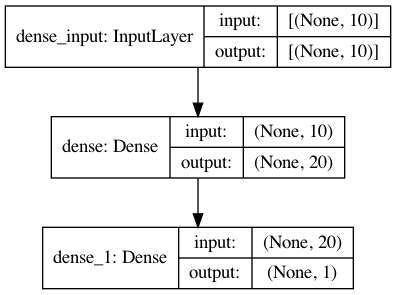

In [20]:
from tensorflow.keras.models import Sequential

# Sequential approach
tf.keras.backend.clear_session() # resets model
model = Sequential()
model.add(Dense(20,activation ='relu',input_shape=(10,)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])
model.summary()

# Plot the model diagram
tf.keras.utils.plot_model(model, show_shapes=True)

### Changing Activation Functions and Depths ###
Let's just really drive things home and show a few more configurations where we change the number our output nodes, add some extra layers, and modify the activation functions:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


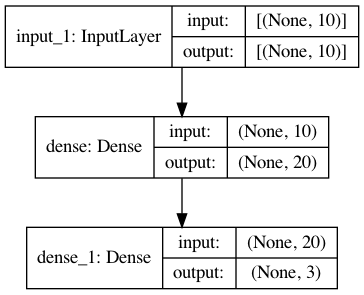

In [21]:
# Predicting three regression variables with sigmoid activation
tf.keras.backend.clear_session() # resets model
input_layer = Input(shape=(10,))
hidden_layer = Dense(20,activation = 'sigmoid')(input_layer)
output_layer = Dense(3)(hidden_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])
model.summary()

# Plot the model diagram
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 63        
Total params: 1,123
Trainable params: 1,123
Non-trainable params: 0
_________________________________________________________________


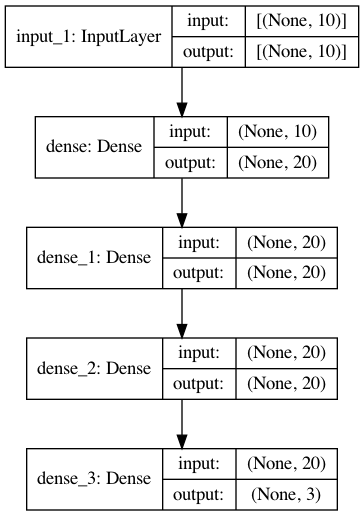

In [23]:
# Building a deeper model with different activation functions
tf.keras.backend.clear_session() # resets model
input_layer = Input(shape=(10,))
hidden_1 = Dense(20,activation = 'sigmoid')(input_layer)
hidden_2 = Dense(20,activation = 'relu')(hidden_1)
hidden_3 = Dense(20,activation = 'softmax')(hidden_2)
output_layer = Dense(3)(hidden_3)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])
model.summary()

# Plot the model diagram
tf.keras.utils.plot_model(model, show_shapes=True)

### Deep Example ###
Let's revisit the pump classification task with a relatively deep model (3 hidden layers, 10 nodes each) and compare the effect of varying the optimizer and activation functions

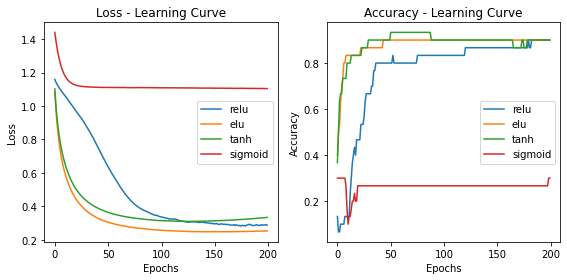

In [51]:
# Initialize dictionaries to hold the models
models = {}

# Loop over distinct activation functions
activations = ['relu','elu','tanh','sigmoid'] 
for i in activations:
    
    # Avoids making duplicate models if you rerun these cells
    tf.keras.backend.clear_session()
    tf.random.set_seed(54238789)
    
    # Initialize input layer (Note the shape, we have four input features)
    model = Sequential()
    model.add(Dense(10,activation=i,input_shape=(4,)))
    model.add(Dense(10,activation=i))
    model.add(Dense(10,activation=i))
    model.add(Dense(3,activation='softmax'))

    # Create the model
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=[Precision(), Recall(), CategoricalAccuracy()])

    # Train the model
    models[i]=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=200,verbose=0,batch_size=10,\
                        validation_data=(scaler.transform(x_test), to_categorical(y_test)))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
for i in activations:
#    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["loss"],label=i)
    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["val_loss"],label=i)
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
for i in activations:
#    plt.plot(np.arange(len(models[i].history["categorical_accuracy"])),models[i].history["categorical_accuracy"],label=i)
    plt.plot(np.arange(len(models[i].history["val_categorical_accuracy"])),models[i].history["val_categorical_accuracy"],label=i)
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()


The sigmoid activation function is the clear outlier (worst). The others have similar behavior, with the relu showing the strongest performance on the validation data. 

Let's test the effect of the optimizer:

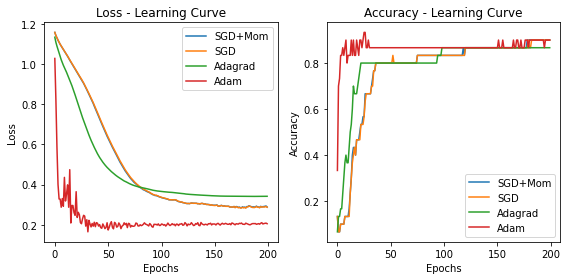

In [50]:
from tensorflow.keras.optimizers import SGD, Adagrad, Adam

optimizers = { "SGD+Mom": SGD(lr=1e-2, nesterov=True,momentum=0.01),\
               "SGD"    : SGD(lr=1e-2, nesterov=False),\
               "Adagrad": Adagrad(lr=1e-2),\
               "Adam"   : Adam(lr=1e-2) }

# Initialize dictionaries to hold the models
models = {}

# Loop over distinct optimizers
for i in optimizers.keys():
    
    # Avoids making duplicate models if you rerun these cells
    tf.keras.backend.clear_session()
    tf.random.set_seed(54238789)
    
    # Initialize input layer (Note the shape, we have four input features)
    model = Sequential()
    model.add(Dense(10,activation='relu',input_shape=(4,)))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    # Create the model
    model.compile(loss='categorical_crossentropy',optimizer=optimizers[i],metrics=[Precision(), Recall(), CategoricalAccuracy()])

    # Train the model
    models[i]=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=200,verbose=0,batch_size=10,\
                        validation_data=(scaler.transform(x_test), to_categorical(y_test)))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
for i in optimizers.keys():
#    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["loss"],label=i)
    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["val_loss"],label=i)
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
for i in optimizers.keys():
#    plt.plot(np.arange(len(models[i].history["categorical_accuracy"])),models[i].history["categorical_accuracy"],label=i)
    plt.plot(np.arange(len(models[i].history["val_categorical_accuracy"])),models[i].history["val_categorical_accuracy"],label=i)
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

Adam converges the quickest (although you should test with other seeds to check reproducibility issues). Let's test the effect of learning rate using Adam/RELU:

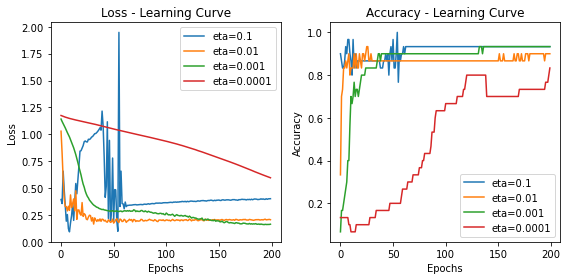

In [49]:
optimizers = { "eta=0.1"    : Adam(lr=1e-1),\
               "eta=0.01"   : Adam(lr=1e-2),\
               "eta=0.001"  : Adam(lr=1e-3),\
               "eta=0.0001" : Adam(lr=1e-4) }

# Initialize dictionaries to hold the models
models = {}

# Loop over distinct optimizers
for i in optimizers.keys():
    
    # Avoids making duplicate models if you rerun these cells
    tf.keras.backend.clear_session()
    tf.random.set_seed(54238789)
    
    # Initialize input layer (Note the shape, we have four input features)
    model = Sequential()
    model.add(Dense(10,activation='relu',input_shape=(4,)))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    # Create the model
    model.compile(loss='categorical_crossentropy',optimizer=optimizers[i],metrics=[Precision(), Recall(), CategoricalAccuracy()])

    # Train the model
    models[i]=model.fit(x=scaler.transform(x_train),y = to_categorical(y_train),epochs=200,verbose=0,batch_size=10,\
                        validation_data=(scaler.transform(x_test), to_categorical(y_test)))

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.subplot(121)
for i in optimizers.keys():
#    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["loss"],label=i)
    plt.plot(np.arange(len(models[i].history["loss"])),models[i].history["val_loss"],label=i)
plt.title('Loss - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
    
# Plot Accuracy Curve
plt.subplot(122)
for i in optimizers.keys():
#    plt.plot(np.arange(len(models[i].history["categorical_accuracy"])),models[i].history["categorical_accuracy"],label=i)
    plt.plot(np.arange(len(models[i].history["val_categorical_accuracy"])),models[i].history["val_categorical_accuracy"],label=i)
plt.title('Accuracy - Learning Curve')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()